In [707]:
import numpy as np
from scipy import linalg
from scipy import signal

In [101]:
# Plotting.
import matplotlib.pyplot as plt

import matplotlib.colors as colors

# nearest neighbor array

In [3]:
def nn_M(k):
    """Constructs force matrix from nearest neighbors."""
    return np.diag(k[1:-1], -1) - np.diag(k[:-1], 0) - np.diag(k[1:], 0) + np.diag(k[1:-1], 1)


In [4]:
node_count = 50

# List of stiffness values for each spring in system.
# should have shape `node_count + 1`
k_identical = np.ones(node_count + 1)

M_identical = nn_M(k_identical)

In [5]:
e, v = linalg.eigh(M_identical)

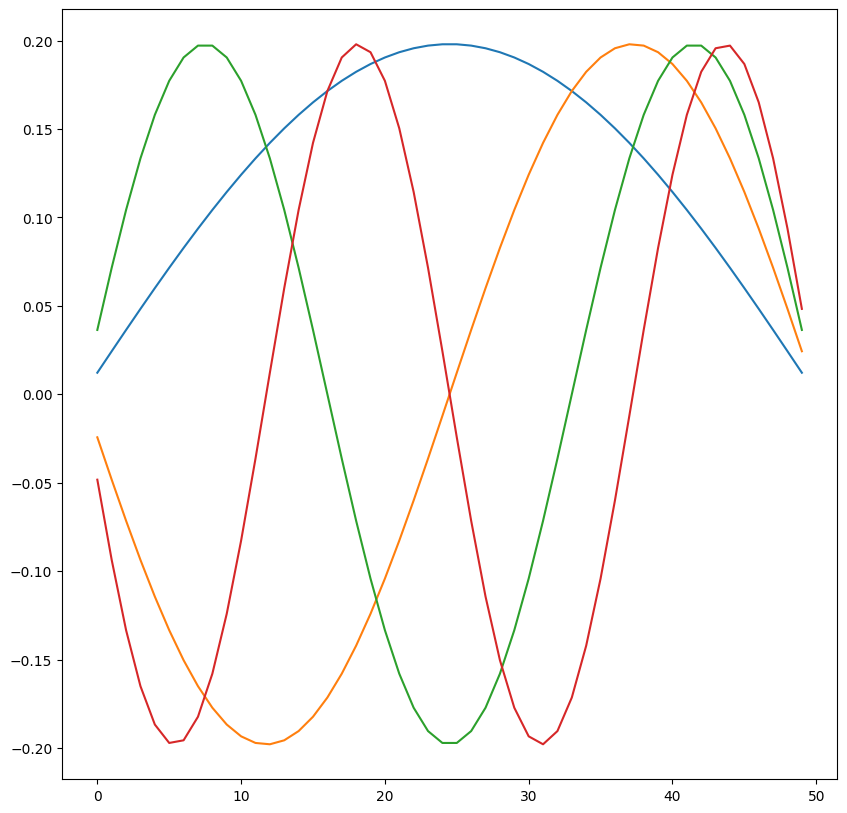

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for i in range(1, 5):
    ax.plot(v[:,-i])

# Symmetric noise

In [618]:
def stiffness_to_force(K):
    """Converts stiffness matrix to linear force.
    
    The stiffness matrix is a symmetric matrix with 0 on the
    main diagonal (as no bonds can exist between the same node).

    
    """
    # diagonal of force matrix.
    F_diag = np.diag(np.sum(K, axis=-1))
    
    # off diagional elements.
    F_off = np.transpose(K) 
    
    return - F_diag + F_off

def fix_boundary(M):
    """Fixing boundary of `M` results in setting force to zero."""
    return M[1:-1, 1:-1]

def add_bond(k, bond_pair, k_new, replace=True):
    if replace:
        k_new = k_new
    else:
        k_new = k_new + k[tuple(bond_pair)]
    k[tuple(bond_pair)] = k[tuple(bond_pair[::-1])] = k_new
    return k

In [744]:
node_count = 1000
nn_k = np.ones(node_count + 1)
k = np.diag(nn_k, 1) + np.diag(nn_k, -1)

# # Add bonds
# bond_pair = np.array([10, 20])
# k = add_bond(k, bond_pair, k_noise)

# # symmetric
# symmetric_bond_pair = node_count - bond_pair
# k = add_bond(k, symmetric_bond_pair, k_noise)

# Add multiple bonds randomly
k_noise = 1
noise_z = node_count * 2
noise_bond_count = noise_z * node_count
bond_pairs = np.random.randint(0, node_count+1, size=(noise_bond_count, 2))
# strength = np.random.rand(noise_bond_count) * k_noise



for b, s in zip(bond_pairs, strength):
    k = add_bond(k, b, k_noise, replace=False)


# Create force matrix.
M = stiffness_to_force(k)
M = fix_boundary(M)

# Find eigenvalues.
e, v = linalg.eigh(M)

v= np.pad(v, [[1,1], [0,0]])

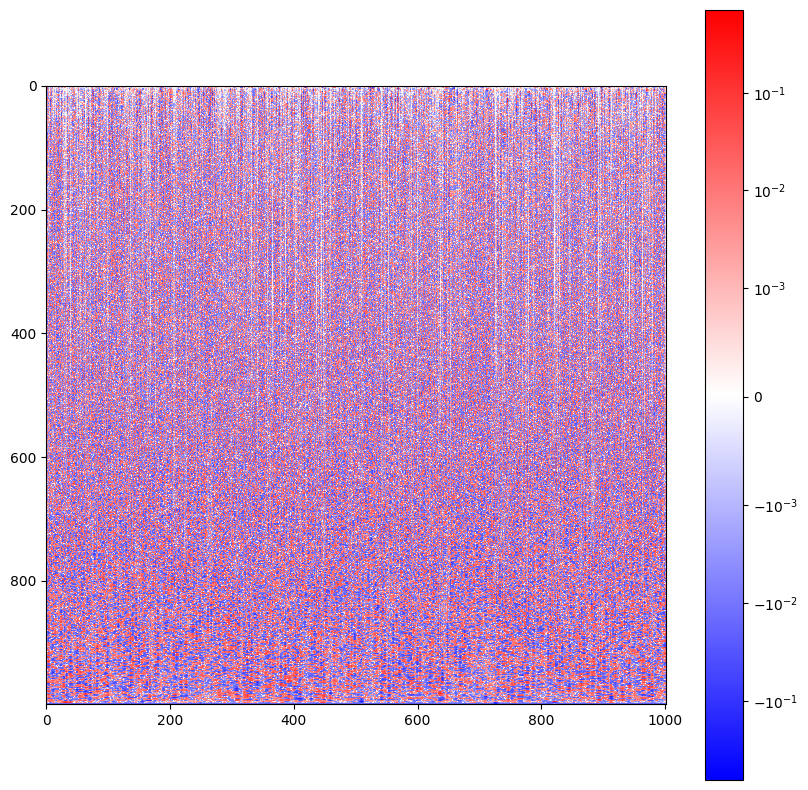

In [745]:
v_plot = np.transpose(v)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = ax.imshow(
    v_plot,
    norm=colors.SymLogNorm(linthresh=.001),
    cmap='bwr',
)
fig.colorbar(p, ax=ax)

# for b in bond_pairs:
#     ax.axvline(b[0], color="yellow")
#     ax.axvline(b[1], color="yellow")




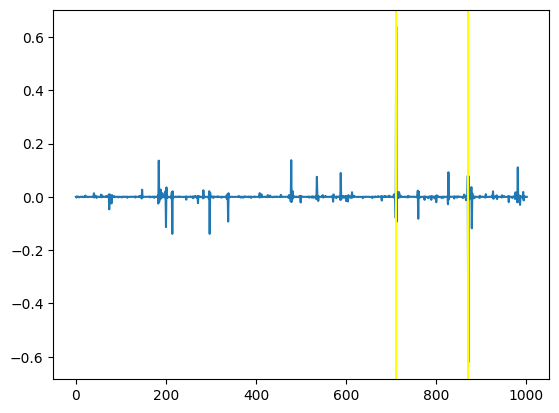

In [746]:
# find peaks.
peak_location, peak_description = signal.find_peaks(np.abs(v_plot[0]), prominence=.4)
peak_location

plt.plot(v_plot[0])
for p in peak_location:
    plt.axvline(p, color='yellow')
    

Text(0.5, 0.98, 'Leading Eigenmodes')

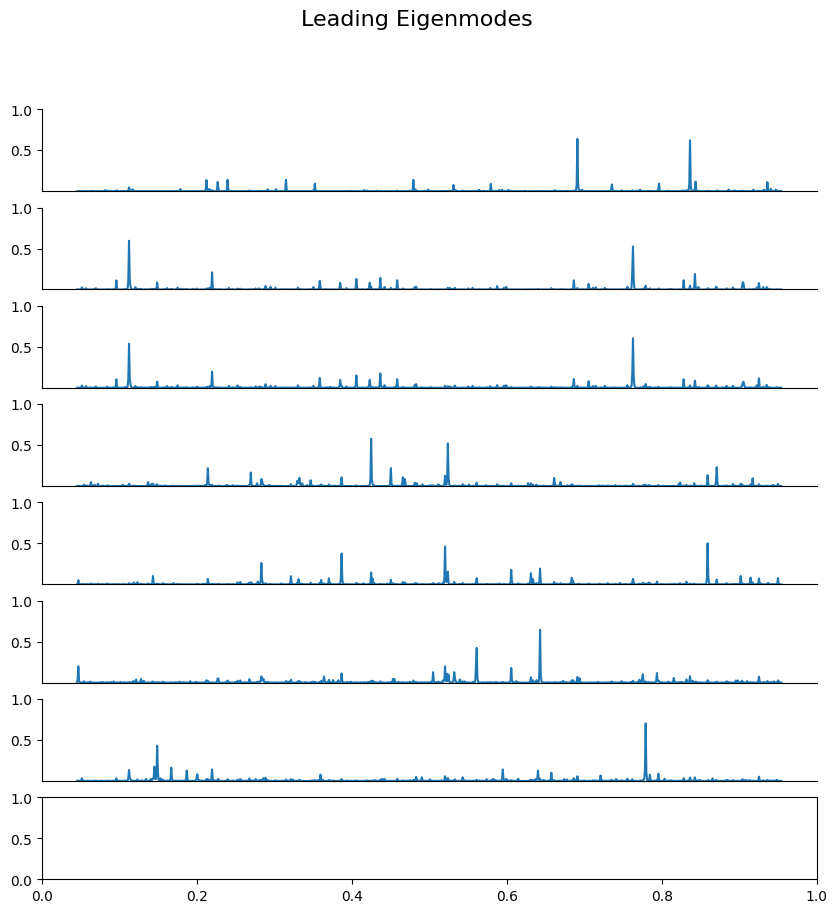

In [747]:
mode_count = 8

fig, ax = plt.subplots(mode_count, 1, figsize=(10,10))

for i in range(0, mode_count-1):
    ax[i].plot(np.abs(v_plot[i]))
#     ax[i].set_yscale('log')
    ax[i].set_ylim(.0001, 1)
    ax[i].tick_params(
    axis='x',          
    which='both',     
    bottom=False,    
    top=False,         
    labelbottom=False
    ) 
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
fig.suptitle("Leading Eigenmodes", fontsize=16)

Text(0.5, 0.98, 'Lowest Eigenmodes')

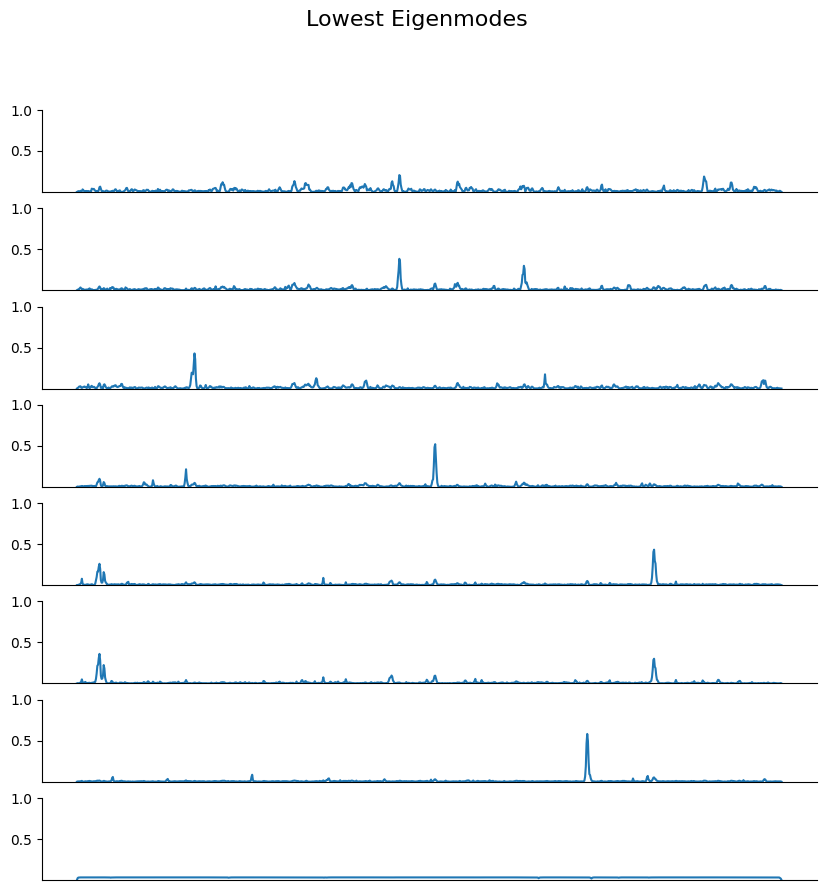

In [748]:
mode_count = 8

fig, ax = plt.subplots(mode_count, 1, figsize=(10,10))

modes = range(node_count - mode_count, node_count)

for i, m in enumerate(modes):
    ax[i].plot(np.abs(v_plot[m]))
#     ax.set_yscale('log')
    ax[i].set_ylim(.0001, 1)
    ax[i].tick_params(
    axis='x',          
    which='both',     
    bottom=False,    
    top=False,         
    labelbottom=False
    ) 
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
fig.suptitle("Lowest Eigenmodes", fontsize=16)

# add small random noise.

In [78]:
def construct_noisy_M(M_0, theta):
    """Adds random interconnections to `M_0`"""
    node_count = M_0.shape[0]
    M_noise = np.random.rand(node_count, node_count)
    return theta * M_noise + M_0

In [94]:
theta = 20

M = construct_noisy_M(M_identical, theta)
e, v = linalg.eigh(M)

v= np.pad(v, [[1,1], [0,0]])

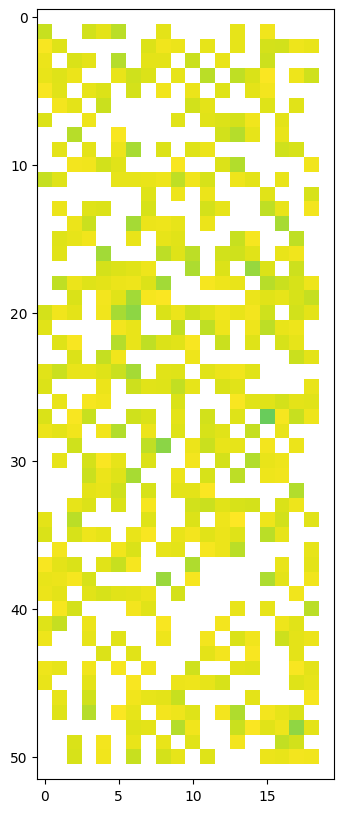

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.imshow(v[:, -20:], norm=colors.LogNorm(vmin=v.min(), vmax=v.max()))

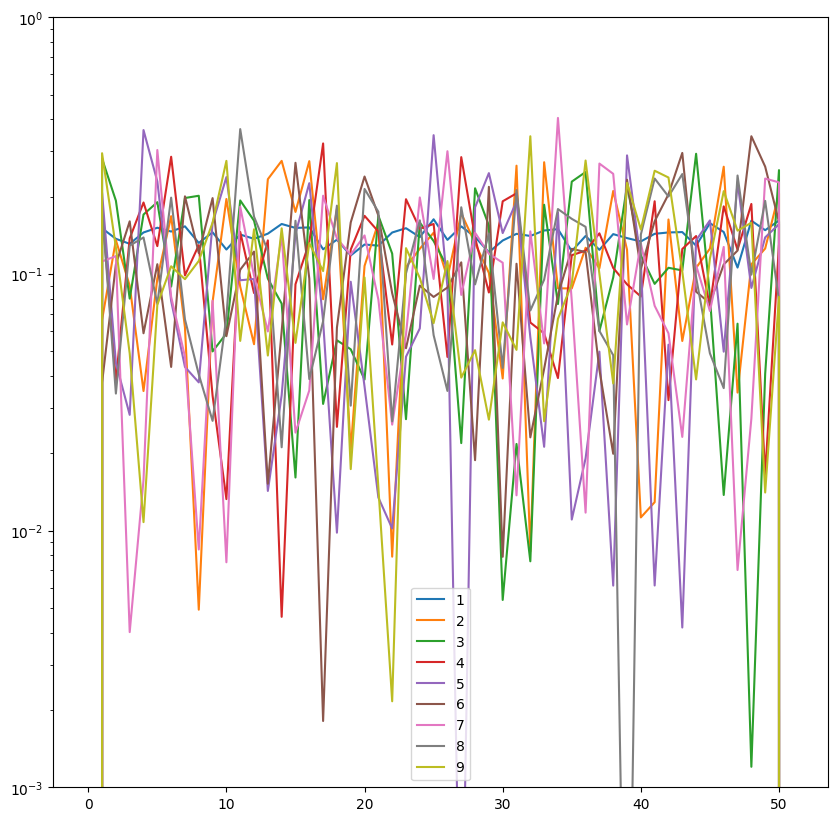

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for i in range(1, 10):
    ax.plot(np.abs(v[:,-i]), label=i)
ax.set_yscale('log')
ax.set_ylim(.001, 1)
ax.legend()

# Ensemble Average

In [74]:
theta = .01

simulation_count = 100

e_set = []
v_set = []

for _ in range(simulation_count):
    M = construct_noisy_M(M_identical, theta)
    e, v = linalg.eigh(M)
    e_set.append(e)
    v_set.append(v)

e = np.stack(e_set, axis=0)
v = np.stack(v_set, axis=0)

In [75]:
v = np.mean(v, axis=0)

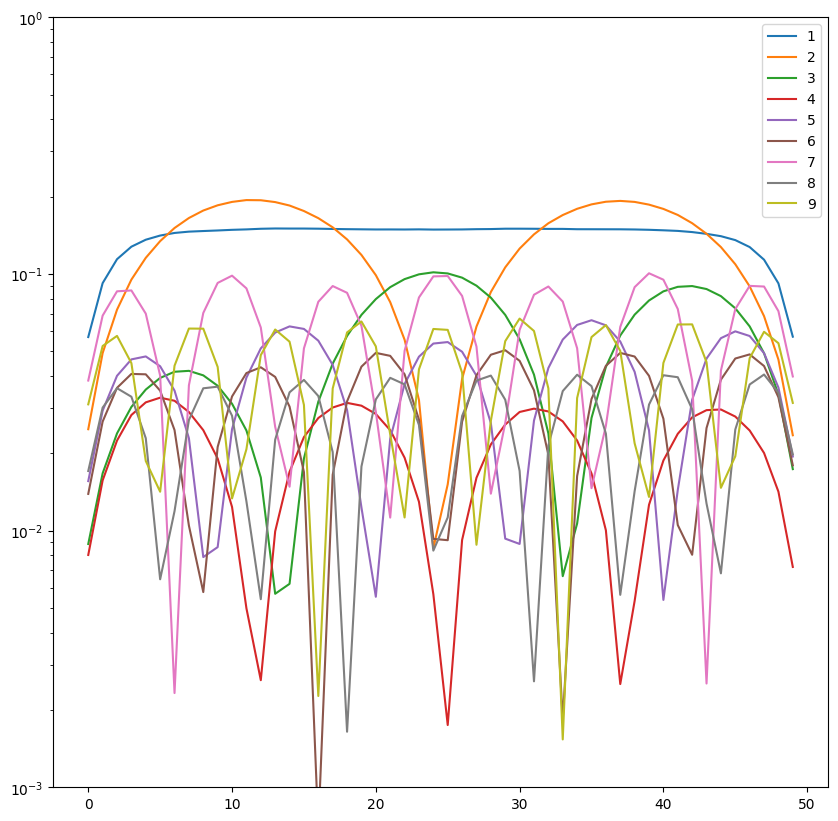

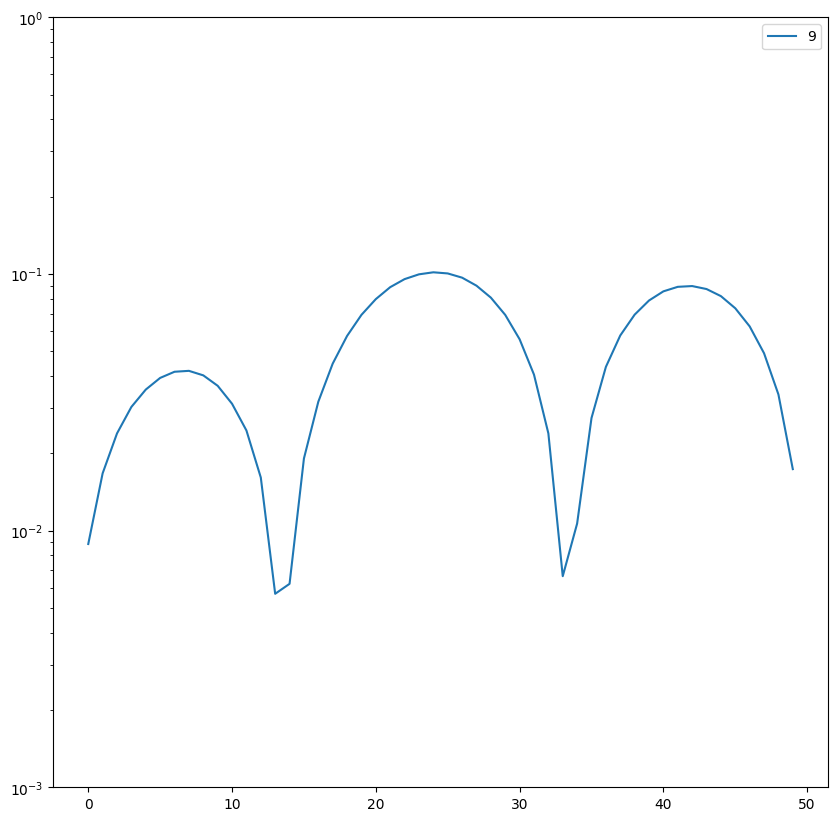

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(np.abs(v[:,-3]), label=i)
ax.set_yscale('log')
ax.set_ylim(.001, 1)
ax.legend()

# animate

In [465]:
import math
import numpy as np

def spring_coords(start, end, nodes, width):
    """!
    Return a list of points corresponding to a spring.
    @param r1 (array-like) The (x, y) coordinates of the first endpoint.
    @param r2 (array-like) The (x, y) coordinates of the second endpoint.
    @param nodes (int) The number of spring "nodes" or coils.
    @param width (int or float) The diameter of the spring.
    @return An array of x coordinates and an array of y coordinates.
    """

    # Check that nodes is at least 1.
    nodes = max(int(nodes), 1)

    # Convert to numpy array to account for inputs of different types/shapes.
    start, end = np.array(start).reshape((2,)), np.array(end).reshape((2,))

    # If both points are coincident, return the x and y coords of one of them.
    if (start == end).all():
        return start[0], start[1]

    # Calculate length of spring (distance between endpoints).
    length = np.linalg.norm(np.subtract(end, start))

    # Calculate unit vectors tangent (u_t) and normal (u_t) to spring.
    u_t = np.subtract(end, start) / length
    u_n = np.array([[0, -1], [1, 0]]).dot(u_t)

    # Initialize array of x (row 0) and y (row 1) coords of the nodes+2 points.
    spring_coords = np.zeros((2, nodes + 2))
    spring_coords[:,0], spring_coords[:,-1] = start, end

    # Check that length is not greater than the total length the spring
    # can extend (otherwise, math domain error will result), and compute the
    # normal distance from the centerline of the spring.
    normal_dist = math.sqrt(max(0, width**2 - (length**2 / nodes**2))) / 2

    # Compute the coordinates of each point (each node).
    for i in range(1, nodes + 1):
        spring_coords[:,i] = (
            start
            + ((length * (2 * i - 1) * u_t) / (2 * nodes))
            + (normal_dist * (-1)**i * u_n))

    return spring_c

In [456]:
from matplotlib.animation import FuncAnimation

In [687]:
%matplotlib inline
# %matplotlib notebook

In [691]:
node_count = 100
nn_k = np.ones(node_count + 1)
k = np.diag(nn_k, 1) + np.diag(nn_k, -1)

# # Add bonds
# bond_pair = np.array([10, 20])
# k = add_bond(k, bond_pair, k_noise)

# # symmetric
# symmetric_bond_pair = node_count - bond_pair
# k = add_bond(k, symmetric_bond_pair, k_noise)

# Add multiple bonds randomly
k_noise = 1
noise_z = node_count * 2
noise_bond_count = noise_z * node_count
bond_pairs = np.random.randint(0, node_count+1, size=(noise_bond_count, 2))
# strength = np.random.rand(noise_bond_count) * k_noise

for b, s in zip(bond_pairs, strength):
    k = add_bond(k, b, k_noise, replace=False)


# Create force matrix.
M = stiffness_to_force(k)
M = fix_boundary(M)

# Find eigenvalues.
e, v = linalg.eigh(M)

v= np.pad(v, [[1,1], [0,0]])

omega = np.sqrt(np.abs(e))

v_plot = np.transpose(v)

o_min = omega.min()

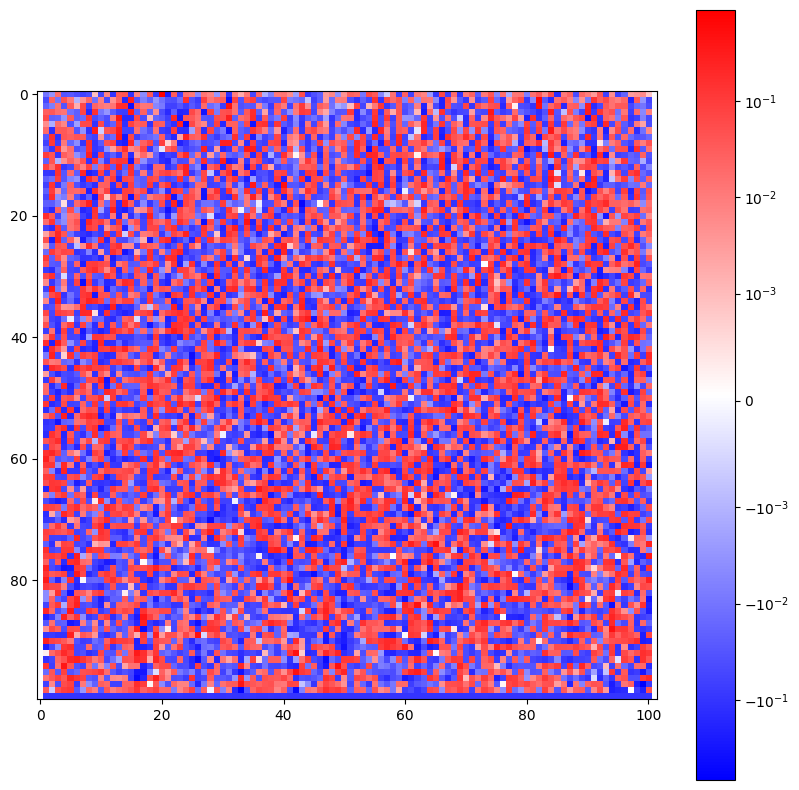

In [692]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = ax.imshow(
    v_plot,
    norm=colors.SymLogNorm(linthresh=.001),
    cmap='bwr',
)
fig.colorbar(p, ax=ax)


Text(0.5, 0.98, 'Leading Eigenmodes')

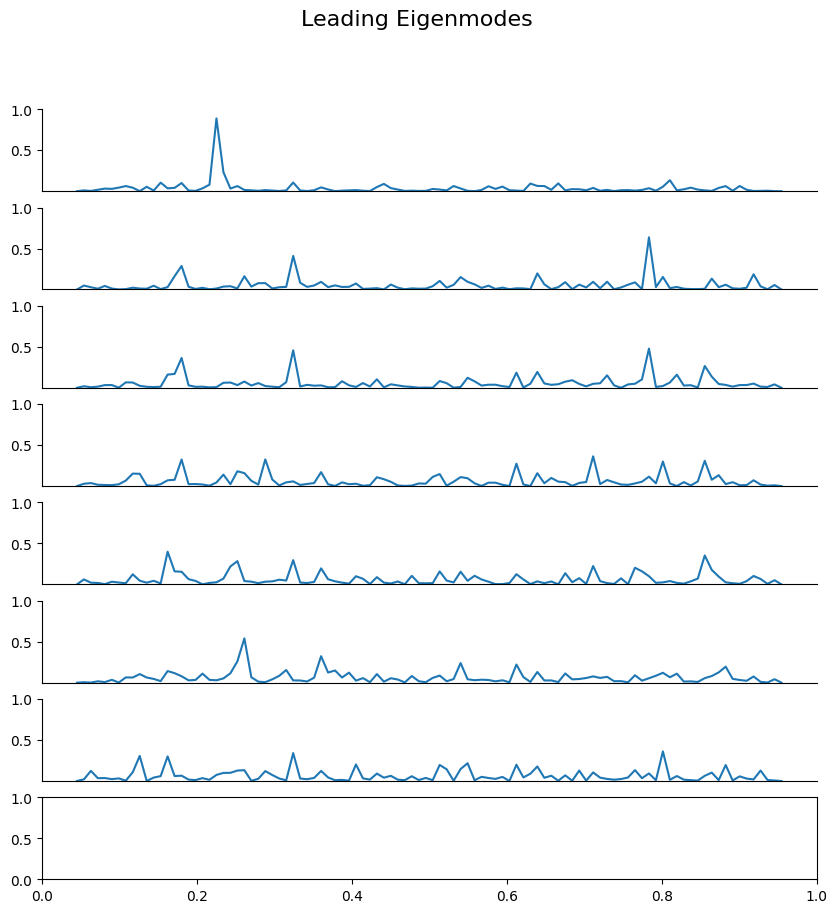

In [693]:
mode_count = 8

fig, ax = plt.subplots(mode_count, 1, figsize=(10,10))

for i in range(0, mode_count-1):
    ax[i].plot(np.abs(v_plot[i]))
#     ax[i].set_yscale('log')
    ax[i].set_ylim(.0001, 1)
    ax[i].tick_params(
    axis='x',          
    which='both',     
    bottom=False,    
    top=False,         
    labelbottom=False
    ) 
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
fig.suptitle("Leading Eigenmodes", fontsize=16)

<IPython.core.display.Javascript object>


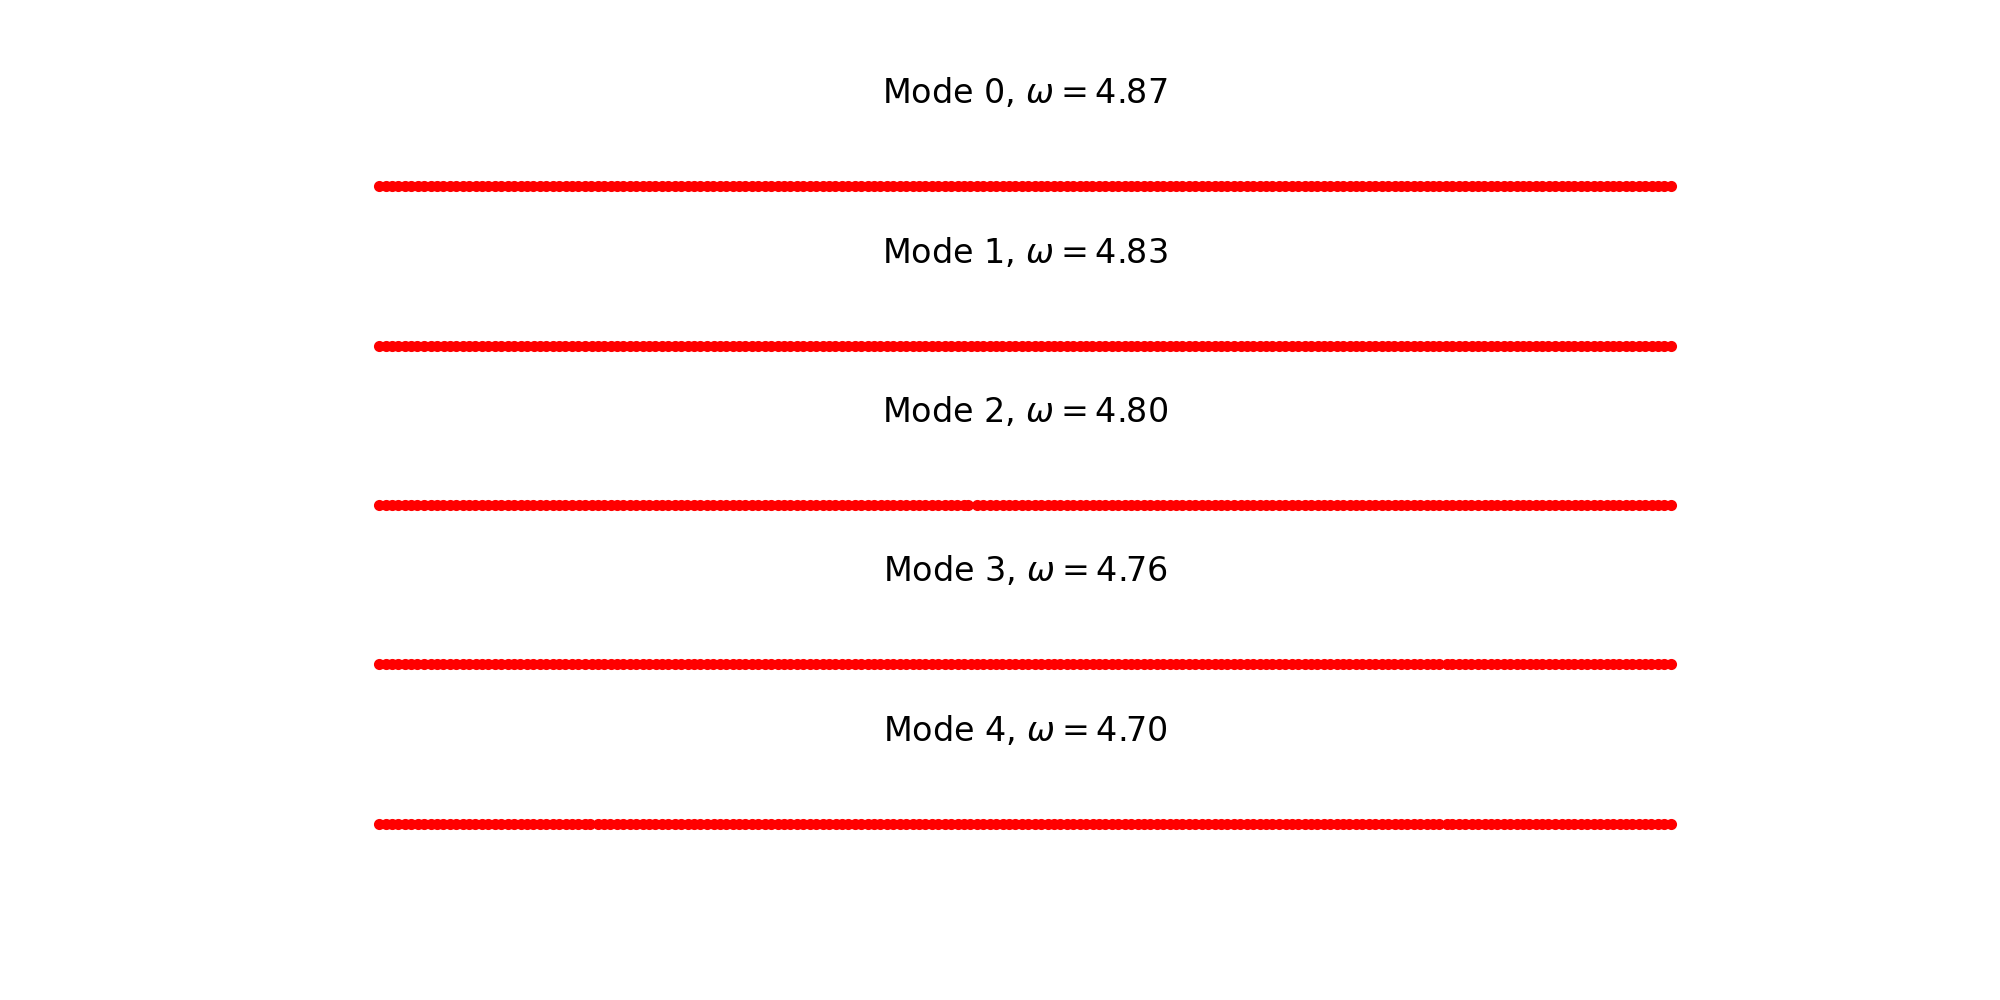

In [685]:
mode_count = 5

x0 = np.linspace(0, 1, node_count + 2)
y0 = np.zeros(node_count + 2)
v =  v_plot[:mode_count] / (node_count + 1) / 2
o = omega[:mode_count]

fig, ax = plt.subplots(mode_count, 1, figsize=(10, 5))

# initialize plotting for each spring.
nodes = [a.plot([], [], 'ro', ms=3)[0] for a in ax]

def init():
    for i, a in enumerate(ax):
        a.set_xlim(-.1, 1.1)
        a.set_ylim(-1, 1)
        a.set_axis_off()
        a.set_title(f"Mode {i}, $\omega = {o[i]:.2f}$")
    return nodes

def update(i):
    u = np.sin(2 * np.pi * i * o / o_min)[:, np.newaxis] * v
    for n, u_ in zip(nodes, u):
        n.set_data(x0 + u_, y0)
    return nodes


fps = 30
ani = FuncAnimation(fig, update, frames=np.linspace(0,1,48), interval = 500/fps,
                    init_func=init, blit=True)

plt.show()

In [635]:
v[0].shape

(8,)

In [509]:
a = plt.plot([], [])

In [510]:
a